In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
options(future.globals.maxSize = 1000000 * 1024^2)
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(sctransform)
library(rliger)
library(SeuratWrappers)
library(conos)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)
library(cowplot)

library(scCustomize)
library(stringr)
library(dittoSeq)
library(DESeq2)
library(enrichR)

library(tidyverse)
library(org.Hs.eg.db)
library(clusterProfiler)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    -- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.0     v purrr   1.0.1
v tidyr   1.3.0     v forcats 1.0.0
v readr   2.1.3     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tibble::as_data_frame() masks dplyr::as_data_frame(), igraph::as_data_frame()
x dplyr::collapse()       masks IRanges::collapse()
x dplyr::combine()        masks Biobase::combine(), BiocGenerics::combine()
x purrr::compose()        masks igraph::compose()
x dplyr::count()          masks matrixStats::count()
x tidyr::crossing()       masks igraph::crossing()
x dplyr::desc()           masks IRanges::desc()
x tidyr::expand()         masks S4Vectors::expand(), Matrix::expand()
x dplyr::filter()         masks stats::filter()
x dplyr::first()       

In [3]:
CellType="CCR7pCD45ROm"
title_plot = "CD45RO-CCR7+"

In [4]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/CoPImmunoPD/"
datadir = projectdir + "Data/"
objtdir = projectdir + "Result/Differnetial_Expression_pct_03/"

resultdir = projectdir + "Result/Differnetial_Expression_pct_03/"+CellType+"/"
adata_file = 'AnnData_Integrated.h5ad'


In [5]:
%%R -i projectdir
setwd(projectdir)

In [6]:
%%R -i objtdir -i resultdir -i projectdir
# setwd(projectdir)
dir.create(objtdir)
dir.create(resultdir)
Subbbb <- readRDS(paste0(projectdir,"Subset_raarranged.rds"))

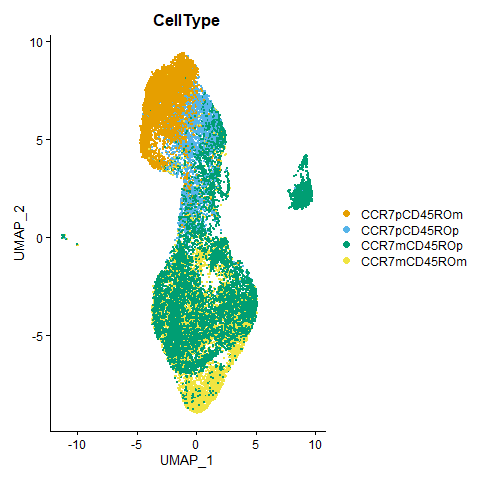

In [7]:
%%R -i resultdir -i projectdir
DimPlot(Subbbb,group.by="CellType",cols=c(dittoColors(1)[seq_len(4)]))

In [8]:
%%R
DefaultAssay(Subbbb) <- "SCT"
# ====== Find markers parameters  ==============
min_pct_threshold = 0.3
# ====== Go enrichment parameters ==============
logfc.threshold <- 0.25
p.val.cutoff <- 0.05
max.genes <- 500


# Subset different CD8 T cells

In [9]:
%%R -i CellType
# ====================== CCR7mCD45ROp ================================
Seurat = subset(Subbbb, idents = CellType)
Seurat<- SetIdent(Seurat , value = "Condition")
Seurat <- PrepSCTFindMarkers(Seurat)

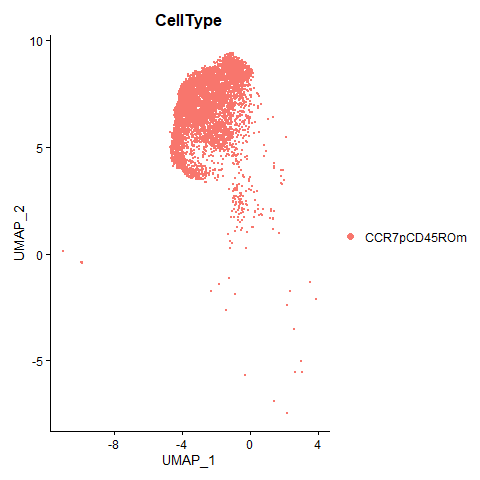

In [10]:
%%R
DimPlot(Seurat,group.by="CellType")

# Create Average Expression

In [11]:
%%R
source(paste0(projectdir,"Functions.R"))

In [12]:
%%R -i resultdir -i CellType
Idents(Seurat) <- "Condition"
Average_Seurat <- AverageExpression(Seurat,return.seurat=T)
Average_Seurat_norm <- as.data.frame(Average_Seurat@assays$SCT@data)
rownames(Average_Seurat_norm) <- rownames(Average_Seurat)
colnames(Average_Seurat_norm)<- paste0(rownames(Average_Seurat@meta.data),"_norm")
Average_Seurat_counts <- as.data.frame(Average_Seurat@assays$RNA@data)
rownames(Average_Seurat_counts) <- rownames(Average_Seurat)
colnames(Average_Seurat_counts)<- paste0(rownames(Average_Seurat@meta.data),"_counts")
Average_Seurat <- as.data.frame(cbind(Average_Seurat_counts,Average_Seurat_norm))
write.csv(Average_Seurat,paste0(resultdir,"Average_",CellType,".csv"))


# Differential Expression

In [13]:
%%R
DE_Seurat_original <-  FindMarkers(Seurat,ident.1="PD",ident.2="HC",
    min.pct = min_pct_threshold,
    logfc.threshold = 0
    )

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~59s           |++                                                | 2 % ~57s           |++                                                | 3 % ~57s           |+++                                               | 4 % ~58s           |+++                                               | 5 % ~59s           |++++                                              | 6 % ~58s           |++++                                              | 7 % ~57s           |+++++                                             | 8 % ~56s           |+++++                                             | 9 % ~55s           |++++++                                            | 10% ~54s           |++++++                                            | 11% ~54s           |+++++++                                           | 12% ~53s           |+++++++                                           | 13% ~52s 

In [14]:
%%R
source("Functions.R")
DE_Seurat <- DE_Seurat_original
DE_Seurat$gene <-  rownames(DE_Seurat)
DE_Seurat  <- gene_score_calc(DE_Seurat)


# ADD ENSEMBL IDs

In [15]:
%%R -i projectdir
gene_names <- as.data.frame(readr::read_tsv(paste0(projectdir,"features.tsv"),col_names =F))
colnames(gene_names) <- c("ensembl.id","gene.name","Type")
DE_Seurat$gene.name <- DE_Seurat$gene


remain_ensembl.id <- gene_names[gene_names$gene.name %in% DE_Seurat$gene.name,]
doublicated_gene <- duplicated(remain_ensembl.id$gene.name)
remain_ensembl.id2 <- remain_ensembl.id[!doublicated_gene,]
rownames(remain_ensembl.id2) <- remain_ensembl.id2$gene.name
DE_Seurat$ensembl.id <- remain_ensembl.id2[DE_Seurat$gene.name,"ensembl.id"]
print(DE_Seurat[1:5,])


Rows: 36601 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): X1, X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
           gene     tstat gene.score p_val p_val_adj diff.pct enrichment.ratio
RNF125   RNF125 -266.6246   -1.50347     0         0   -0.200          1.27548
ZFP36L2 ZFP36L2 -254.0397   -0.99831     0         0   -0.047          1.04963
CNOT6L   CNOT6L -229.0696   -1.11585     0         0   -0.118          1.14200
P2RY8     P2RY8 -208.3705   -1.42069     0         0   -0.231          1.35538
TXNIP     TXNIP  188.9837    0.73517     0         0    0.029          1.03014
        pct.1 pct.2 avg_log2FC cluster gene.name      ensembl.id
RNF125  0.726 0.926   -1.17875      HC    RNF125 ENSG00000101695
ZFP36L2 0.947 0.994   -0.95111      HC   ZFP36L2 ENSG00000152518
CNOT6L  0.831 0.949   -0.97711      

# ADD ENTREZ IDs

In [16]:
%%R
source("Functions.R")
rownames(DE_Seurat) <- DE_Seurat$gene.name
geneIDs <- DE_Seurat[,c("gene.name","ensembl.id")]
DE_Seurat_mapped <- entrezMapper(DEGenes=DE_Seurat, geneIDs=geneIDs, species="hsa")



FALSE  TRUE 
 2981    23 


In [17]:
%%R
cleanDEGenes <- DE_Seurat_mapped[!is.na(DE_Seurat_mapped$entrezID),]
print(dim(cleanDEGenes))
print(dim(DE_Seurat_mapped))

[1] 2981   14
[1] 3004   14


In [18]:
%%R
DE_Seurat_signif <- cleanDEGenes %>%
  filter(abs(avg_log2FC)>0.25 &  p_val_adj <0.05) %>%
  arrange(desc(abs(gene.score)))
DE_Seurat_signif[1:5,]

                 gene      tstat gene.score p_val p_val_adj diff.pct
AC099489.1 AC099489.1 -102.40464   -2.61704     0         0   -0.249
RNF125         RNF125 -266.62464   -1.50347     0         0   -0.200
P2RY8           P2RY8 -208.37050   -1.42069     0         0   -0.231
HIST1H1E     HIST1H1E   91.55809    1.33506     0         0    0.238
TUBB4B         TUBB4B -142.74568   -1.30216     0         0   -0.319
           enrichment.ratio pct.1 pct.2 avg_log2FC cluster  gene.name
AC099489.1          3.73622 0.091 0.340   -0.70045      HC AC099489.1
RNF125              1.27548 0.726 0.926   -1.17875      HC     RNF125
P2RY8               1.35538 0.650 0.881   -1.04818      HC      P2RY8
HIST1H1E            2.59730 0.387 0.149    0.51402      PD   HIST1H1E
TUBB4B              1.93548 0.341 0.660   -0.67278      HC     TUBB4B
                ensembl.id entrezID
AC099489.1 ENSG00000188897   400499
RNF125     ENSG00000101695    54941
P2RY8      ENSG00000182162

   286530
HIST1H1E   ENSG00000168298     3008
TUBB4B     ENSG00000188229    10383


In [19]:
%%R -i CellType
Average_subset_ordered <- Average_Seurat[DE_Seurat$gene,]
DE_Seurat <- as.data.frame(cbind(DE_Seurat,Average_subset_ordered))
DE_Seurat <- DE_Seurat[order(DE_Seurat$gene.score,decreasing=T),]
readr::write_csv(DE_Seurat,
    file=paste0(resultdir,CellType,"DEG_MinPct_",min_pct_threshold,".csv"))


                   p_val avg_log2FC pct.1 pct.2     p_val_adj       gene
AC099489.1 2.978519e-107 -0.7004506 0.091 0.340 3.938794e-103 AC099489.1
RNF125     1.794706e-271 -1.1787515 0.726 0.926 2.373320e-267     RNF125
P2RY8      3.222057e-213 -1.0481807 0.650 0.881 4.260848e-209      P2RY8
HIST1H1E    2.091950e-96  0.5140204 0.387 0.149  2.766395e-92   HIST1H1E
TUBB4B     1.358181e-147 -0.6727843 0.341 0.660 1.796058e-143     TUBB4B
FMN1        9.017034e-71 -0.5246406 0.149 0.364  1.192413e-66       FMN1
            gene.name cluster enrichment.ratio diff.pct      tstat gene.score
AC099489.1 AC099489.1      HC         3.736223   -0.249 -102.40464  -2.617039
RNF125         RNF125      HC         1.275480   -0.200 -266.62464  -1.503474
P2RY8           P2RY8      HC         1.355383   -0.231 -208.37050  -1.420686
HIST1H1E     HIST1H1E      PD         2.597298    0.238   91.55809   1.335064
TUBB4B         TUBB4B      HC         1.935478   -0.319 -142.74568  -1.302159
FMN1             FMN1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


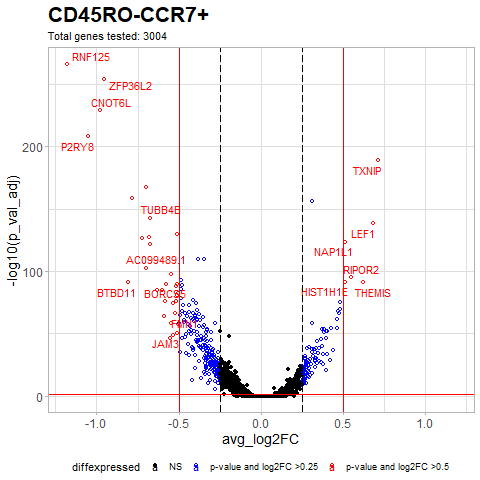

In [85]:
%%R -i resultdir -i title_plot
source("Functions.R")
library(ggrepel)
Vlcano_df <- DE_Seurat_original
Vlcano_df$gene <- rownames(Vlcano_df)
Vlcano_df$gene.name <- rownames(Vlcano_df)
Vlcano_df$cluster = ifelse(Vlcano_df$avg_log2FC >0 , "PD" ,"HC")
Vlcano_df$enrichment.ratio = ifelse(Vlcano_df$pct.1>Vlcano_df$pct.2, Vlcano_df$pct.1 / (Vlcano_df$pct.2 + .000001), Vlcano_df$pct.2 / (Vlcano_df$pct.1 + .000001))
Vlcano_df$diff.pct = Vlcano_df$pct.1 - Vlcano_df$pct.2
Vlcano_df$tstat= -log10(Vlcano_df$p_val_adj + 1e-320) * sign(Vlcano_df$avg_log2FC) 
Vlcano_df$gene.score = Vlcano_df$avg_log2FC * Vlcano_df$enrichment.ratio
Vlcano_df <- Vlcano_df  %>% arrange(desc(abs(gene.score)))
print(head(Vlcano_df))

up_labs   <- rownames(Vlcano_df %>% filter(avg_log2FC > 0.5 , p_val_adj<0.05 ))[1:10]
down_labs <- rownames(Vlcano_df %>% filter(avg_log2FC < -0.5 , p_val_adj < 0.05))[1:10]


# add a column of NAs
Vlcano_df$diffexpressed <- "NO"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
Vlcano_df$diffexpressed[Vlcano_df$avg_log2FC > 0.5 & Vlcano_df$p_val < 0.05] <- "UP"
# if log2Foldchange < -0.6 and pvalue < 0.05, set as "DOWN"
Vlcano_df$diffexpressed[Vlcano_df$avg_log2FC < -0.5 & Vlcano_df$p_val < 0.05] <- "DOWN"
Vlcano_df$delabel <- NA
# Vlcano_df$delabel[Vlcano_df$diffexpressed != "NO"] <- Vlcano_df$gene.name[Vlcano_df$diffexpressed != "NO"]
Vlcano_df$delabel[Vlcano_df$gene.name %in% c(up_labs,down_labs)] <- Vlcano_df$gene.name[Vlcano_df$gene.name %in% c(up_labs,down_labs)]


x_lim <- max(abs(Vlcano_df$avg_log2FC))


# p <- ggplot(data=Vlcano_df, aes(x=avg_log2FC, y=-log10(p_val), col=diffexpressed, label=delabel,shape=diffexpressed)) +
#         geom_point() + 
#         theme_cowplot()  + theme_light()+
#         geom_text_repel() +
#         scale_shape_manual(values =c(1,19,1)) +
#         scale_color_manual(values=c("blue", "black", "red")) +
#         geom_vline(xintercept=c(-0.5, 0.5), col="red") +
#         geom_hline(yintercept=-log10(0.05), col="red")+
#         ggtitle(title_plot, subtitle = paste0("Total genes tested: ",dim(Vlcano_df)[1] ))+
#         xlim(-x_lim,x_lim)+
#         theme(legend.position="bottom",
#         legend.spacing.x = unit(0, 'cm'))
# ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.png"))
# ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.pdf"))


# add a column of NAs
Vlcano_df$diffexpressed <- "NS"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
Vlcano_df$diffexpressed[(Vlcano_df$avg_log2FC > 0.25 & Vlcano_df$p_val_adj < 0.05) | (Vlcano_df$avg_log2FC < -0.25 & Vlcano_df$p_val_adj < 0.05)] <- "p-value and log2FC >0.25"
Vlcano_df$diffexpressed[(Vlcano_df$avg_log2FC > 0.5 & Vlcano_df$p_val_adj < 0.05) | (Vlcano_df$avg_log2FC < -0.5 & Vlcano_df$p_val_adj < 0.05)] <-  "p-value and log2FC >0.5"
Vlcano_df$delabel <- NA
Vlcano_df$delabel[Vlcano_df$gene.name %in% c(up_labs,down_labs)] <- Vlcano_df$gene.name[Vlcano_df$gene.name %in% c(up_labs,down_labs)]

p <- ggplot(data=Vlcano_df, aes(x=avg_log2FC, y=-log10(p_val_adj), col=diffexpressed, label=delabel,shape=diffexpressed)) +
        geom_point() + 
        theme_cowplot()  + theme_light()+
        geom_text_repel() +
        scale_shape_manual(values =c(19,1,1)) +
        scale_color_manual(values=c("black","blue","red")) +
        geom_vline(xintercept=c(-0.25, 0.25), col="black", linetype = "longdash") +
        
        geom_vline(xintercept=c(-0.5, 0.5), col="red") +
        geom_hline(yintercept=-log10(0.05), col="red")+
        ggtitle(title_plot, subtitle = paste0("Total genes tested: ",dim(Vlcano_df)[1] ))+
        xlim(-x_lim,x_lim)+
        theme(legend.position="bottom", legend.box="vertical", legend.margin=margin(),
                # legend.spacing.x = unit(0, 'cm'),
                plot.title = element_text(size = 21,face = "bold"),
                axis.text=element_text(size=12),
                axis.title=element_text(size=14))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.pdf"))
p
# p+guides(fill=guide_legend(nrow=2,byrow=TRUE))

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


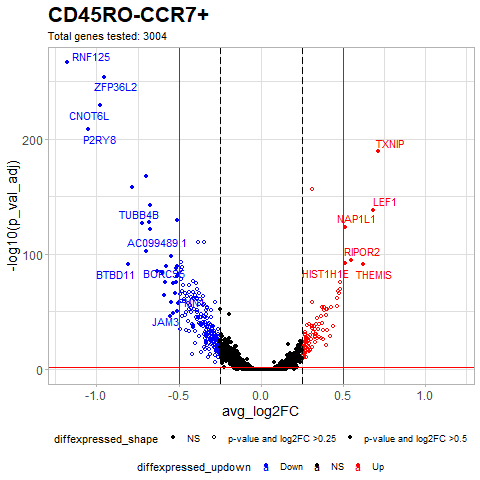

In [97]:
%%R -i resultdir -i title_plot
source("Functions.R")
library(ggrepel)
Vlcano_df <- DE_Seurat_original
Vlcano_df$gene <- rownames(Vlcano_df)
Vlcano_df$gene.name <- rownames(Vlcano_df)
Vlcano_df$cluster = ifelse(Vlcano_df$avg_log2FC >0 , "PD" ,"HC")
Vlcano_df$enrichment.ratio = ifelse(Vlcano_df$pct.1>Vlcano_df$pct.2, Vlcano_df$pct.1 / (Vlcano_df$pct.2 + .000001), Vlcano_df$pct.2 / (Vlcano_df$pct.1 + .000001))
Vlcano_df$diff.pct = Vlcano_df$pct.1 - Vlcano_df$pct.2
Vlcano_df$tstat= -log10(Vlcano_df$p_val_adj + 1e-320) * sign(Vlcano_df$avg_log2FC) 
Vlcano_df$gene.score = Vlcano_df$avg_log2FC * Vlcano_df$enrichment.ratio
Vlcano_df <- Vlcano_df  %>% arrange(desc(abs(gene.score)))

up_labs   <- rownames(Vlcano_df %>% filter(avg_log2FC > 0.5 , p_val_adj<0.05 ))[1:10]
down_labs <- rownames(Vlcano_df %>% filter(avg_log2FC < -0.5 , p_val_adj < 0.05))[1:10]
x_lim <- max(abs(Vlcano_df$avg_log2FC))

# add a column of NAs
Vlcano_df$diffexpressed_updown <- "NS"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
Vlcano_df$diffexpressed_updown[(Vlcano_df$avg_log2FC > 0.25 & Vlcano_df$p_val_adj < 0.05)] <- "Up"
Vlcano_df$diffexpressed_updown[(Vlcano_df$avg_log2FC < -0.25 & Vlcano_df$p_val_adj < 0.05)] <- "Down"
# add a column of NAs
Vlcano_df$diffexpressed_shape <- "NS"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
Vlcano_df$diffexpressed_shape[(Vlcano_df$avg_log2FC > 0.25 & Vlcano_df$p_val_adj < 0.05) | (Vlcano_df$avg_log2FC < -0.25 & Vlcano_df$p_val_adj < 0.05)] <- "p-value and log2FC >0.25"
Vlcano_df$diffexpressed_shape[(Vlcano_df$avg_log2FC > 0.5 & Vlcano_df$p_val_adj < 0.05) | (Vlcano_df$avg_log2FC < -0.5 & Vlcano_df$p_val_adj < 0.05)] <-  "p-value and log2FC >0.5"
Vlcano_df$delabel <- NA
Vlcano_df$delabel[Vlcano_df$gene.name %in% c(up_labs,down_labs)] <- Vlcano_df$gene.name[Vlcano_df$gene.name %in% c(up_labs,down_labs)]

p <- ggplot(data=Vlcano_df, aes(x=avg_log2FC, y=-log10(p_val_adj), col=diffexpressed_updown, label=delabel,shape=diffexpressed_shape)) +
        geom_point() + 
        theme_cowplot()  + theme_light()+
        geom_text_repel() +
        scale_shape_manual(values =c(19,1,19)) +
        scale_color_manual(values=c("blue","black","red")) +
        geom_vline(xintercept=c(-0.25, 0.25), col="black", linetype = "longdash") +
        geom_vline(xintercept=c(-0.5, 0.5), col="red") +
        geom_hline(yintercept=-log10(0.05), col="red")+
        ggtitle(title_plot, subtitle = paste0("Total genes tested: ",dim(Vlcano_df)[1] ))+
        xlim(-x_lim,x_lim)+
        theme(legend.position="bottom", legend.box="vertical", legend.margin=margin(),
                # legend.spacing.x = unit(0, 'cm'),
                plot.title = element_text(size = 21,face = "bold"),
                axis.text=element_text(size=12),
                axis.title=element_text(size=14))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.pdf"))
p

# Kegg Pathway

## Possitive PD

In [21]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
kegg_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
                     KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1       T cell receptor signaling pathway             ratio 6/104
2 Human T-cell leukemia virus 1 infection             ratio 6/219
3               Th17 cell differentiation             ratio 4/107


In [22]:
%%R
print("Take a break enrichr crashes")


[1] "Take a break enrichr crashes"


## Negative PD

In [23]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
kegg_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
  KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1          Hepatitis B            ratio 10/162
2            Apoptosis             ratio 9/142
3    Colorectal cancer              ratio 7/86


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


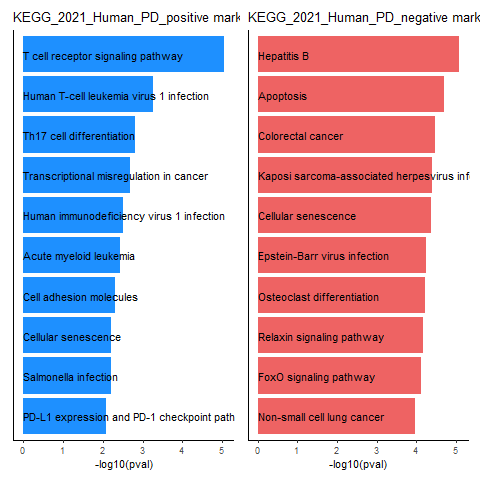

In [24]:
%%R
enrich.database <- "KEGG_2021_Human"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = kegg_pos_mat,
        neg.er = kegg_neg_mat,
        enrich.database= enrich.database )


ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

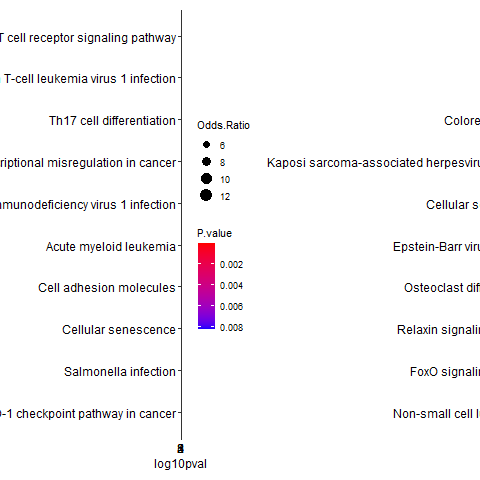

In [25]:
%%R
source("Functions.R")
enrich.database <- "KEGG_2021_Human"
p <- dotplot_enrich_dim(pos_mat=kegg_pos_mat , neg_mat=kegg_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)

p



# Reactome Pathway

## Possitive PD

In [26]:
%%R
source("Functions.R")
enrich.database <- c("Reactome_2022")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])




pos_IDs <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
pos_mat$term <- pos_Term
pos_mat$term <- factor(pos_Term,levels= pos_Term)

reactome_pos_mat <- pos_mat  


readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                                                                 Reactome_2022.Term
1 RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells R-HSA-8939246
2                                       Constitutive Signaling By Overexpressed ERBB2 R-HSA-9634285
3                                               HuR (ELAVL1) Binds And Stabilizes mRNA R-HSA-450520
  Reactome_2022.Overlap
1             ratio 2/7
2            ratio 2/10
3            ratio 2/10


## Negative PD

In [27]:
%%R
source("Functions.R")
enrich.database<- c("Reactome_2022")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])


neg_IDs <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
neg_mat$term <- neg_Term

reactome_neg_mat <- neg_mat  

readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                 Reactome_2022.Term Reactome_2022.Overlap
1 Cytokine Signaling In Immune System R-HSA-1280215          ratio 28/702
2            Signaling By Interleukins R-HSA-449147          ratio 20/453
3                        Immune System R-HSA-168256         ratio 45/1943


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


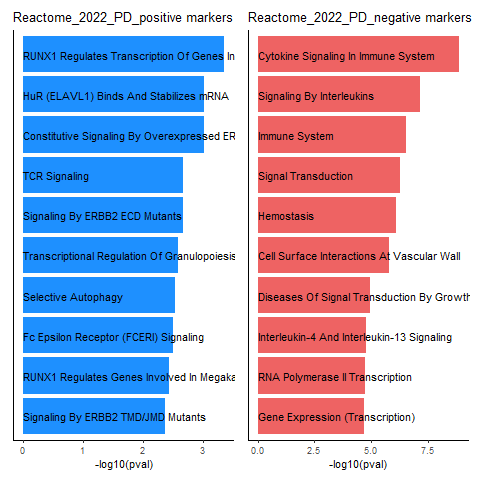

In [28]:
%%R
enrich.database <- "Reactome_2022"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = reactome_pos_mat,
        neg.er = reactome_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

In [29]:
%%R
colnames(reactome_neg_mat)

 [1] "Reactome_2022.Term"                 "Reactome_2022.Overlap"             
 [3] "Reactome_2022.P.value"              "Reactome_2022.Adjusted.P.value"    
 [5] "Reactome_2022.Old.P.value"          "Reactome_2022.Old.Adjusted.P.value"
 [7] "Reactome_2022.Odds.Ratio"           "Reactome_2022.Combined.Score"      
 [9] "Reactome_2022.Genes"                "log10pval"                         
[11] "term"                               "ID"                                


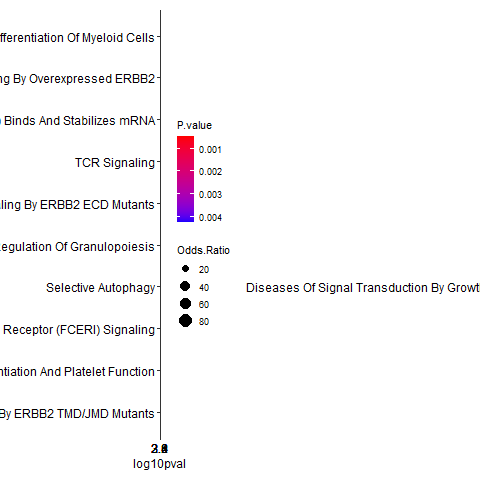

In [30]:
%%R
source("Functions.R")
enrich.database <- "Reactome_2022"
p <- dotplot_enrich_dim(pos_mat=reactome_pos_mat , neg_mat=reactome_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p



# GO Pathway

## Possitive PD

In [31]:
%%R
source("Functions.R")
enrich.database <- c("GO_Biological_Process_2021")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
go_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                           GO_Biological_Process_2021.Term
1           T cell receptor signaling pathway (GO:0050852)
2 antigen receptor-mediated signaling pathway (GO:0050851)
3                  mRNA splice site selection (GO:0006376)
  GO_Biological_Process_2021.Overlap
1                        ratio 8/158
2                        ratio 8/185
3                         ratio 4/30


## Negative PD

In [32]:
%%R
source("Functions.R")
enrich.database<- c("GO_Biological_Process_2021")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
go_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                                             GO_Biological_Process_2021.Term
1                        cellular response to cytokine stimulus (GO:0071345)
2                           cytokine-mediated signaling pathway (GO:0019221)
3 cellular response to transforming growth factor beta stimulus (GO:0071560)
  GO_Biological_Process_2021.Overlap
1                       ratio 21/482
2                       ratio 22/621
3                        ratio 9/114


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


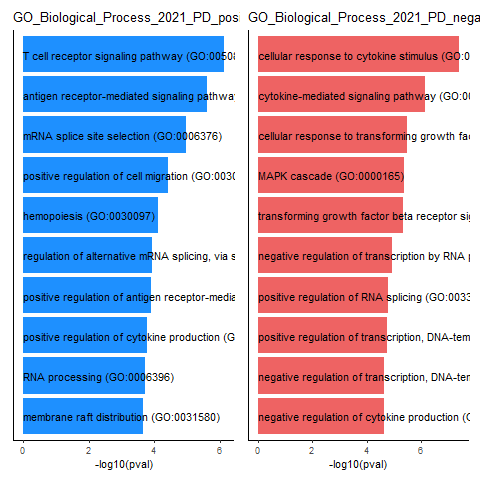

In [33]:
%%R
enrich.database <- "GO_Biological_Process_2021"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = go_pos_mat,
        neg.er = go_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

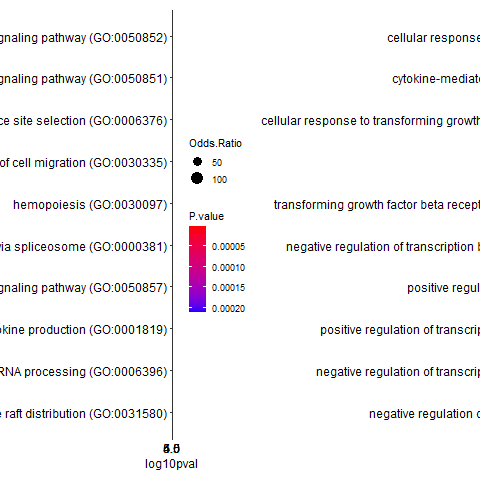

In [34]:
%%R
source("Functions.R")
enrich.database <- "GO_Biological_Process_2021"
p <- dotplot_enrich_dim(pos_mat=go_pos_mat , neg_mat=go_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p

# Calculate RANKS based on FC

In [35]:
%%R
ranks_avg_log2FC<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , avg_log2FC   )) 
ranks_avg_log2FC[1:4]
gsea_kegg_log2FC <- gseKEGG(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))

#  TOP UP GSEA KEGG

In [36]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "T cell receptor signaling pathway"
[1] "Human T-cell leukemia virus 1 infection"
[1] "Th17 cell differentiation"
[1] "Transcriptional misregulation in cancer"
[1] "Human immunodeficiency virus 1 infection"
[1] "Acute myeloid leukemia"
[1] "Cell adhesion molecules"
[1] "Cellular senescence"
[1] "Salmonella infection"
[1] "PD-L1 expression and PD-1 checkpoint pathway in cancer"


# TOP Down GSEA KEGG

In [37]:
%%R
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Hepatitis B"
[1] "Apoptosis"
[1] "Colorectal cancer"
[1] "Kaposi sarcoma-associated herpesvirus infection"
[1] "Cellular senescence"
[1] "Epstein-Barr virus infection"
[1] "Osteoclast differentiation"
[1] "Relaxin signaling pathway"
[1] "FoxO signaling pathway"
[1] "Non-small cell lung cancer"


In [38]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_log2FC <- gsePathway(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_log2FC),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))
gsea_reactome_log2FC[1:3,"Description"]

[1] "Formation of Senescence-Associated Heterochromatin Foci (SAHF)"
[2] "Apoptosis induced DNA fragmentation"                           
[3] "Transmission across Chemical Synapses"                         


# TOP UP GSEA REACTOME

In [39]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}


[1] "RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells"
[1] "Constitutive Signaling By Overexpressed ERBB2"
[1] "HuR (ELAVL1) Binds And Stabilizes mRNA"
[1] "TCR Signaling"
[1] "Signaling By ERBB2 ECD Mutants"
[1] "Transcriptional Regulation Of Granulopoiesis"
[1] "Selective Autophagy"
[1] "Fc Epsilon Receptor (FCERI) Signaling"
[1] "RUNX1 Regulates Genes Involved In Megakaryocyte Differentiation And Platelet Function"
[1] "Signaling By ERBB2 TMD/JMD Mutants"


In [40]:
%%R
gsea_reactome_log2FC

#
# Gene Set Enrichment Analysis
#
#...@organism 	 human 
#...@setType 	 Reactome 
#...@keytype 	 ENTREZID 
#...@geneList 	 Named num [1:3004] 0.714 0.684 0.619 0.546 0.514 ...
 - attr(*, "names")= chr [1:3004] "10628" "51176" "387357" "9750" ...
#...nPerm 	 10000 
#...pvalues adjusted by 'BH' with cutoff <1 
#...1887 enriched terms found
'data.frame':	1887 obs. of  11 variables:
 $ ID             : chr  "R-HSA-2559584" "R-HSA-140342" "R-HSA-112315" "R-HSA-418555" ...
 $ Description    : chr  "Formation of Senescence-Associated Heterochromatin Foci (SAHF)" "Apoptosis induced DNA fragmentation" "Transmission across Chemical Synapses" "G alpha (s) signalling events" ...
 $ setSize        : int  8 7 41 21 35 9 4 9 5 50 ...
 $ enrichmentScore: num  0.84 0.85 -0.616 -0.69 -0.613 ...
 $ NES            : num  1.97 1.91 -1.89 -1.85 -1.82 ...
 $ pvalue         : num  0.00076 0.001472 0.000136 0.001633 0.000976 ...
 $ p.adjust       : num  0.193 0.193 0.193 0.193 0.193 ...
 $ qvalue         : nu

## TOP Down GSEA REACTOME

In [41]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Cytokine Signaling In Immune System"
[1] "Signaling By Interleukins"
[1] "Immune System"
[1] "Signal Transduction"
[1] "Hemostasis"
[1] "Cell Surface Interactions At Vascular Wall"
[1] "Diseases Of Signal Transduction By Growth Factor Receptors And Second Messengers"
[1] "Interleukin-4 And Interleukin-13 Signaling"
[1] "RNA Polymerase II Transcription"
[1] "Gene Expression (Transcription)"


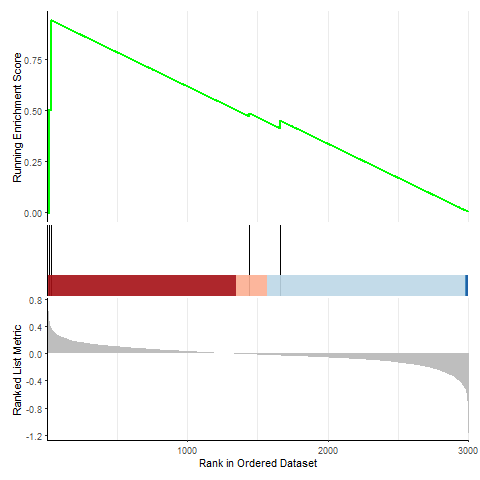

In [42]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_log2FC, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_Ranks_log2FC.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# Calculate RANKS based on Gene score

In [43]:
%%R
# Calculate RANKS based on genescore
ranks_avg_genescore<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , gene.score )) 
ranks_avg_genescore[1:4]
gsea_kegg_genescore <- gseKEGG(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))

In [44]:
%%R
kegg_pos_mat[1,]

               KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1 T cell receptor signaling pathway             ratio 6/104
  KEGG_2021_Human.P.value KEGG_2021_Human.Adjusted.P.value
1            9.034105e-06                      0.001382218
  KEGG_2021_Human.Old.P.value KEGG_2021_Human.Old.Adjusted.P.value
1                           0                                    0
  KEGG_2021_Human.Odds.Ratio KEGG_2021_Human.Combined.Score
1                   13.94018                       161.9083
                KEGG_2021_Human.Genes log10pval
1 PTPRC;PIK3CD;CD3G;LCP2;PRKCQ;CARD11  5.044115
                               term
1 T cell receptor signaling pathway


In [45]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}


[1] "T cell receptor signaling pathway"
[1] "Human T-cell leukemia virus 1 infection"
[1] "Th17 cell differentiation"
[1] "Transcriptional misregulation in cancer"
[1] "Human immunodeficiency virus 1 infection"
[1] "Acute myeloid leukemia"
[1] "Cell adhesion molecules"
[1] "Cellular senescence"
[1] "Salmonella infection"
[1] "PD-L1 expression and PD-1 checkpoint pathway in cancer"


In [46]:
%%R
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Hepatitis B"
[1] "Apoptosis"
[1] "Colorectal cancer"
[1] "Kaposi sarcoma-associated herpesvirus infection"
[1] "Cellular senescence"
[1] "Epstein-Barr virus infection"
[1] "Osteoclast differentiation"
[1] "Relaxin signaling pathway"
[1] "FoxO signaling pathway"
[1] "Non-small cell lung cancer"


In [47]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_genescore <- gsePathway(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_genescore),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))
gsea_reactome_genescore[1:3,"Description"]
# TOP UP GSEA REACTOME

[1] "Formation of Senescence-Associated Heterochromatin Foci (SAHF)"
[2] "Carboxyterminal post-translational modifications of tubulin"   
[3] "Apoptotic execution phase"                                     


In [48]:
%%R 
pos_IDs <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_pos_mat$term <- pos_Term

neg_IDs <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_neg_mat$term <- neg_Term

In [49]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}

[1] "RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells"
[1] "Constitutive Signaling By Overexpressed ERBB2"
[1] "HuR (ELAVL1) Binds And Stabilizes mRNA"
[1] "TCR Signaling"
[1] "Signaling By ERBB2 ECD Mutants"
[1] "Transcriptional Regulation Of Granulopoiesis"
[1] "Selective Autophagy"
[1] "Fc Epsilon Receptor (FCERI) Signaling"
[1] "RUNX1 Regulates Genes Involved In Megakaryocyte Differentiation And Platelet Function"
[1] "Signaling By ERBB2 TMD/JMD Mutants"


In [50]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Cytokine Signaling In Immune System"
[1] "Signaling By Interleukins"
[1] "Immune System"
[1] "Signal Transduction"
[1] "Hemostasis"
[1] "Cell Surface Interactions At Vascular Wall"
[1] "Diseases Of Signal Transduction By Growth Factor Receptors And Second Messengers"
[1] "Interleukin-4 And Interleukin-13 Signaling"
[1] "RNA Polymerase II Transcription"
[1] "Gene Expression (Transcription)"


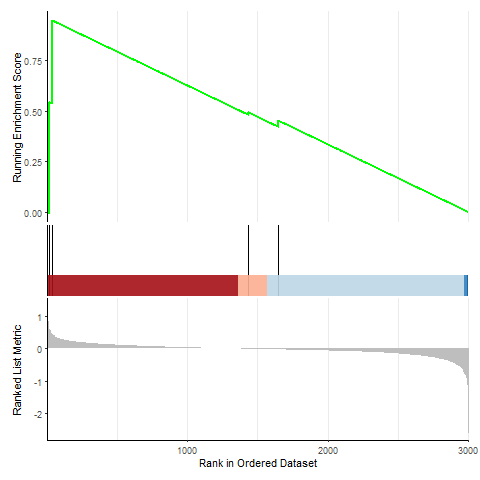

In [51]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_genescore, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.thres_",logfc.threshold,
        "_Ranks_gs.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# KEGG GSEA ONLY POSSITIVE & ONLY NEG

In [52]:
%%R
library(enrichplot)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_kegg_genescore_pos <- gseKEGG(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_pos  <- gsea_kegg_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_kegg_genescore_neg <- gseKEGG(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_neg  <- gsea_kegg_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [53]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_pos$ID[row_iter]
    text_term <- gsea_kegg_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [54]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_pos[match(tolower(as.vector(kegg_pos_mat$term)[1:10]),tolower(gsea_kegg_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot_ONLY_POS/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [55]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_neg$ID[row_iter]
    text_term <- gsea_kegg_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_genescore_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [56]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_neg[match(tolower(as.vector(kegg_neg_mat$term[1:10])),tolower(gsea_kegg_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

# Reactome GSEA ONLY POSSITIVE & ONLY NEG

In [57]:
%%R
library(ReactomePA)
require(clusterProfiler)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_Reactome_genescore_pos <- gsePathway(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_Reactome_genescore_pos  <- gsea_Reactome_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_Reactome_genescore_neg <- gsePathway(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only neg enriched
gsea_Reactome_genescore_neg  <- gsea_Reactome_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [58]:
%%R
head(gsea_Reactome_genescore_pos)

                         ID
R-HSA-2559586 R-HSA-2559586
R-HSA-2559584 R-HSA-2559584
R-HSA-2559583 R-HSA-2559583
R-HSA-75153     R-HSA-75153
R-HSA-390522   R-HSA-390522
R-HSA-140342   R-HSA-140342
                                                                 Description
R-HSA-2559586                  DNA Damage/Telomere Stress Induced Senescence
R-HSA-2559584 Formation of Senescence-Associated Heterochromatin Foci (SAHF)
R-HSA-2559583                                            Cellular Senescence
R-HSA-75153                                        Apoptotic execution phase
R-HSA-390522                                     Striated Muscle Contraction
R-HSA-140342                             Apoptosis induced DNA fragmentation
              setSize enrichmentScore      NES       pvalue  p.adjust    qvalue
R-HSA-2559586       9       0.8906892 1.836659 0.0002118195 0.1127586 0.1127474
R-HSA-2559584       6       0.9337028 1.786728 0.0001124986 0.1127586 0.1127474
R-HSA-2559583      25    

In [59]:
%%R
head(gsea_Reactome_genescore_neg)

                         ID
R-HSA-109582   R-HSA-109582
R-HSA-9609736 R-HSA-9609736
R-HSA-6785807 R-HSA-6785807
R-HSA-389977   R-HSA-389977
R-HSA-373076   R-HSA-373076
R-HSA-9668328 R-HSA-9668328
                                                           Description setSize
R-HSA-109582                                                Hemostasis      87
R-HSA-9609736 Assembly and cell surface presentation of NMDA receptors       4
R-HSA-6785807               Interleukin-4 and Interleukin-13 signaling      16
R-HSA-389977                   Post-chaperonin tubulin folding pathway       4
R-HSA-373076                      Class A/1 (Rhodopsin-like receptors)       5
R-HSA-9668328        Sealing of the nuclear envelope (NE) by ESCRT-III       4
              enrichmentScore       NES      pvalue  p.adjust    qvalue rank
R-HSA-109582       -0.5945959 -1.367773 0.000399960 0.6907309 0.6879312  328
R-HSA-9609736      -0.9389189 -1.585997 0.003099430 0.7821512 0.7789809   86
R-HSA-6785807      -

In [60]:
%%R
as.vector(reactome_pos_mat$term)[1:10]

 [1] "RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells"  
 [2] "Constitutive Signaling By Overexpressed ERBB2"                                        
 [3] "HuR (ELAVL1) Binds And Stabilizes mRNA"                                               
 [4] "TCR Signaling"                                                                        
 [5] "Signaling By ERBB2 ECD Mutants"                                                       
 [6] "Transcriptional Regulation Of Granulopoiesis"                                         
 [7] "Selective Autophagy"                                                                  
 [8] "Fc Epsilon Receptor (FCERI) Signaling"                                                
 [9] "RUNX1 Regulates Genes Involved In Megakaryocyte Differentiation And Platelet Function"
[10] "Signaling By ERBB2 TMD/JMD Mutants"                                                   


In [61]:
%%R
tolower(gsea_Reactome_genescore_pos$Description)[1:10]

 [1] "dna damage/telomere stress induced senescence"                                      
 [2] "formation of senescence-associated heterochromatin foci (sahf)"                     
 [3] "cellular senescence"                                                                
 [4] "apoptotic execution phase"                                                          
 [5] "striated muscle contraction"                                                        
 [6] "apoptosis induced dna fragmentation"                                                
 [7] "runx1 regulates transcription of genes involved in differentiation of myeloid cells"
 [8] "runx2 regulates genes involved in differentiation of myeloid cells"                 
 [9] "formation of the beta-catenin:tcf transactivating complex"                          
[10] "rnd3 gtpase cycle"                                                                  


In [62]:
%%R
gsea_Reactome_genescore_pos$Description[1:10]

 [1] "DNA Damage/Telomere Stress Induced Senescence"                                      
 [2] "Formation of Senescence-Associated Heterochromatin Foci (SAHF)"                     
 [3] "Cellular Senescence"                                                                
 [4] "Apoptotic execution phase"                                                          
 [5] "Striated Muscle Contraction"                                                        
 [6] "Apoptosis induced DNA fragmentation"                                                
 [7] "RUNX1 regulates transcription of genes involved in differentiation of myeloid cells"
 [8] "RUNX2 regulates genes involved in differentiation of myeloid cells"                 
 [9] "Formation of the beta-catenin:TCF transactivating complex"                          
[10] "RND3 GTPase cycle"                                                                  


In [63]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_pos$ID[row_iter]
    text_term <- gsea_Reactome_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [64]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_pos[match(tolower(as.vector(reactome_pos_mat$term))[1:10],tolower(gsea_Reactome_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))
top_pos <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] 10 11


In [65]:
%%R
# ====================================== PLOTTING  neg =====================================================================
temp_dir <- paste0(resultdir,"Top10_Downreg_GSEA_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)

for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_neg$ID[row_iter]
    text_term <- gsea_Reactome_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [66]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_neg[match(tolower(as.vector(reactome_neg_mat$term)[1:10]),tolower(gsea_Reactome_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))

top_neg <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1]  9 11


# END

In [67]:
%%R
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ReactomePA_1.42.0           enrichplot_1.18.4          
 [3] EnhancedVolcano_1.16.0      ggrepel_0.9.2              
 [5] clusterProfiler_4.6.2       org.Hs.eg.db_3.16.0        
 [7] AnnotationDbi_1.60.2        forcats_1.0.0              
 [9] purrr_1.0.1                 readr_2.1.3                
[11] tidyr_1.3.0                 tibble_3.2.0               
[13] tidyverse_1.3.2             enrichR_3.2                
[15] DESeq2_1.38.3               dittoSeq_1.10.0      